# Singapore Weather Prediction

In [2]:
# setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as pyo
import requests
import tensorflow as tf
import os

from datetime import datetime, timedelta
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from pmdarima import auto_arima
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from time import time

px.defaults.template = 'plotly' # plotly, plotly_dark
pyo.init_notebook_mode(connected=True)
pio.renderers.default = "iframe" # must trust notebook for it to work, use iframe for lab

# Set the seed for numpy module
np.random.seed(123)

# Set the seed for tensorflow module
tf.random.set_seed(123)

### Data Acquisition

Data source: [data.gov.sg](https://data.gov.sg/) - National Environment Agency

Data format: CKAN APIs 
- access to static tabular data such as time series or listings
- alternative to the data.gov.sg web interface
- provides both RESTful and functional interfaces, all in JSON format, making it suitable for a wide range of clients.

API used: CKAN Datastore Search
- GET URL with endpoint: https://data.gov.sg/api/action/datastore_search

| Name               | Description                                                                                                                                                                                                                                                                                                                                                      |
|:-------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **resource_id \*** | ID or alias of the resource to be searched against                                                                                                                                                                                                                                                                                                               |
| limit              | Maximum number of rows to return (optional, default: 100)<br>_Default value_: 100                                                                                                                                                                                                                                                                                |
| offset             | Offset this number of rows (optional)                                                                                                                                                                                                                                                                                                                            |
| fields             | Fields to return (optional, default: all fields in original order)                                                                                                                                                                                                                                                                                               |
| filters            | Dictionary of matching conditions, e.g., {"key1": "a", "key2": "b"} (optional)                                                                                                                                                                                                                                                                                   |
| q                  | Full text query. If it’s a string, it’ll search on all fields on each row.<br>If it’s a dictionary as {"key1": "a", "key2": "b"}, it’ll search on each specific field (optional)                                                                                                                                                                                 |
| sort               | Comma-separated field names with ordering, e.g.: "fieldname1, fieldname2 desc" (optional)                                                                                                                                                                                                                                                                        |
| records_format     | The format for the records return value:<br>'objects' (default) list of {fieldname1: value1, ...} dicts,<br>'lists' list of [value1, value2, ...] lists,<br>'csv' string containing comma-separated values with no header,<br>'tsv' string containing tab-separated values with no header<br>_Available values_: objects, lists, csv<br>_Default value_: objects |

| Variable                                                          | Columns (renamed)              |
|:------------------------------------------------------------------|:-------------------------------|
| Surface Air Temperature - Monthly Mean \(°C\)                     | month, mean_temp               |
| Surface Air Temperature - Monthly Absolute Extreme Maximum \(°C\) | month, max_temp                |
| Surface Air Temperature - Monthly Absolute Extreme Minimum \(°C\) | month, min_temp                |
| Rainfall - Monthly Total \(mm\)                                   | month, total_rainfall          |
| Rainfall - Monthly Maximum Daily Total  \(mm\)                    | month, max_rainfall_daily      |
| Rainfall - Monthly Number of Rain Days \(d\)                      | month, num_rainy_days          |
| Relative Humidity - Monthly Mean \(%\)                            | month, mean_rh                 |
| Relative Humidity - Monthly Absolute Extreme Minimum \(%\)        | month, min_rh                  |
| Sunshine Duration- Monthly Mean Daily Duration \(h\)              | month, mean_sunshine_hrs_daily |


In [3]:
api_endpoint = "https://data.gov.sg/api/action/datastore_search"

# resource ids
surface_air_temp_monthly_mean_resource_id = "07654ce7-f97f-49c9-81c6-bd41beba4e96"
# surface_air_temp_monthly_abs_extreme_max_resource_id = "96e66346-68bb-4ca9-b001-58bbf39e36a7"
# surface_air_temp_monthly_abs_extreme_min_resource_id = "0c5b9752-2488-46cc-ae1c-42318d0f8865"
rainfall_monthly_total_resource_id = "778814b8-1b96-404b-9ac9-68d6c00e637b"
# rainfall_monthly_max_daily_total_resource_id = "df4d391e-6950-4fc6-80cd-c9b9ef6354fe"
# rainfall_monthly_num_rain_days_resource_id = "8b94f596-91fd-4545-bf9e-7a426493b674"
# relative_humidity_monthly_mean_resource_id = "4631174f-9858-463d-8a88-f3cb21588c67"
# relative_humidity_monthly_abs_extreme_min_resource_id = "585c24a5-76cd-4c48-9341-9223de5adc1d"
# sunshine_duration_monthly_mean_daily_resource_id = "0230819f-1c83-4980-b738-56136d6dc300"

resource_ids = [surface_air_temp_monthly_mean_resource_id, rainfall_monthly_total_resource_id]

# resource_ids = [surface_air_temp_monthly_mean_resource_id,
# surface_air_temp_monthly_abs_extreme_max_resource_id,
# surface_air_temp_monthly_abs_extreme_min_resource_id,
# rainfall_monthly_total_resource_id,
# rainfall_monthly_max_daily_total_resource_id,
# rainfall_monthly_num_rain_days_resource_id,
# relative_humidity_monthly_mean_resource_id,
# relative_humidity_monthly_abs_extreme_min_resource_id,
# sunshine_duration_monthly_mean_daily_resource_id]

# call APIs
merged_df = None
for resource_id in resource_ids:
    url = api_endpoint + "?resource_id=" + resource_id + "&limit=1000"
    response = requests.get(url).json()
    data = response['result']['records']
    df = pd.DataFrame(data).set_index('month').drop('_id', axis=1)
    if merged_df is None:
        print("Acquiring data...")
        merged_df = df
        continue
    merged_df = pd.merge(merged_df, df, on='month')

print(merged_df)

Acquiring data...
        mean_temp total_rainfall
month                           
1982-01      25.9          107.1
1982-02      27.1           27.8
1982-03      27.2          160.8
1982-04        27            157
1982-05        28          102.2
...           ...            ...
2022-12      26.8          215.4
2023-01      26.5          302.6
2023-02      26.9          324.4
2023-03      27.1          243.4
2023-04      28.5          222.8

[496 rows x 2 columns]


### Data Preprocessing

Rename columns, convert data types, handle missing values, data cleaning, ensuring data is in suitable format for modeling.

In [4]:
# rename columns
new_names = {'max_temperature': 'max_temp', 'temp_extremes_min': 'min_temp', 'maximum_rainfall_in_a_day': 'max_rainfall_daily', 'no_of_rainy_days': 'num_rainy_days', 'rh_extremes_minimum': 'min_rh', 'mean_sunshine_hrs': 'mean_sunshine_hrs_daily'}
df = merged_df.rename(columns=new_names)
df = df.rename_axis('datetime')
df.index = pd.to_datetime(df.index)
# df['year'] = df.index.year.astype('int64')
# df['month'] = df.index.month.astype('int64')
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='raise')
# start_datetime = pd.to_datetime('2010-01-01')
# df = df[start_datetime:]
print(df)
# df.head()
# print(df.dtypes)

            mean_temp  total_rainfall
datetime                             
1982-01-01       25.9           107.1
1982-02-01       27.1            27.8
1982-03-01       27.2           160.8
1982-04-01       27.0           157.0
1982-05-01       28.0           102.2
...               ...             ...
2022-12-01       26.8           215.4
2023-01-01       26.5           302.6
2023-02-01       26.9           324.4
2023-03-01       27.1           243.4
2023-04-01       28.5           222.8

[496 rows x 2 columns]


#### Data Visualisation

In [5]:
series_monthly_mean_temp = df['mean_temp'].resample('M').mean()  # resample to monthly mean
# print(series_monthly_mean_temp)

# line plot for mean temperature
fig_monthly_mean_temp = px.line(series_monthly_mean_temp, labels={series_monthly_mean_temp.index.name: 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Monthly Mean Temperature')
fig_monthly_mean_temp.update_xaxes(dtick='M12', tickangle=45)
fig_monthly_mean_temp.update_yaxes(dtick=0.5, tickangle=45)
fig_monthly_mean_temp.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')

# add the mean line
mean_temperature = np.mean(series_monthly_mean_temp)
fig_monthly_mean_temp.add_shape(
    type="line",
    x0=series_monthly_mean_temp.index[0],
    y0=mean_temperature,
    x1=series_monthly_mean_temp.index[-1],
    y1=mean_temperature,
    line=dict(color="red", dash="dot"),
)
fig_monthly_mean_temp.show()

# series_monthly_total_rainfall = df['total_rainfall'].resample('M').mean()  # resample to monthly mean
# # series_yearly_total_rainfall = df['total_rainfall'].resample('Y').mean()  # resample to yearly mean

# # print(monthly_total_rainfall)
# # print(series_yearly_total_rainfall)

# # line plot for total rainfall
# fig_monthly_total_rainfall = px.line(monthly_total_rainfall, labels={series_monthly_total_rainfall.index.name: 'Datetime', 'value': 'Total Rainfall (mm)'},title='Monthly Total Rainfall')
# fig_monthly_total_rainfall.update_xaxes(dtick='M12', tickangle=45)
# fig_monthly_total_rainfall.update_yaxes(dtick=100, tickangle=45)
# fig_monthly_total_rainfall.update_traces(hovertemplate='Datetime: %{x}<br>Total Rainfall: %{y}mm')

# # add the mean line
# mean_total_rainfall = np.mean(series_monthly_total_rainfall)
# fig_monthly_total_rainfall.add_shape(
#     type="line",
#     x0=series_monthly_total_rainfall.index[0],
#     y0=mean_total_rainfall,
#     x1=series_monthly_total_rainfall.index[-1],
#     y1=mean_total_rainfall,
#     line=dict(color="red", dash="dot"),
# )
# fig_monthly_total_rainfall.show()

# # Normalize mean temperature data
# normalized_mean_temp = preprocessing.scale(series_monthly_mean_temp)
# # Normalize total rainfall data
# normalized_total_rainfall = preprocessing.scale(series_monthly_total_rainfall)

# # Create a DataFrame with normalized data
# df_normalized = pd.DataFrame({'Datetime': series_monthly_mean_temp.index,
#                               'Normalized Mean Temperature': normalized_mean_temp,
#                               'Normalized Total Rainfall': normalized_total_rainfall})

# # Combine the normalized data using plotly.express
# fig_combined = px.line(df_normalized, x='Datetime', y=['Normalized Mean Temperature', 'Normalized Total Rainfall'],
#                        labels={'value': 'Normalized Value'},
#                        title='Combined Normalized Data')
# fig_combined.update_xaxes(dtick='M12', tickangle=45)
# fig_combined.update_yaxes(dtick=1, tickangle=45)
# fig_combined.update_traces(hovertemplate='Datetime: %{x}<br>Total Rainfall: %{y}mm')

# # Show the combined graph
# fig_combined.show()

In [6]:
series_yearly_mean_temp = df['mean_temp'].resample('Y').mean()  # resample to yearly mean
# print(series_yearly_mean_temp)

fig_yearly_mean_temp = px.line(series_yearly_mean_temp, labels={series_yearly_mean_temp.index.name: 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Yearly Mean Temperature')
fig_yearly_mean_temp.update_xaxes(dtick='M12', tickangle=45)
fig_yearly_mean_temp.update_yaxes(dtick=0.5, tickangle=45)
fig_yearly_mean_temp.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')

# add the mean line
mean_temperature = np.mean(series_yearly_mean_temp)
fig_yearly_mean_temp.add_shape(
    type="line",
    x0=series_yearly_mean_temp.index[0],
    y0=mean_temperature,
    x1=series_yearly_mean_temp.index[-1],
    y1=mean_temperature,
    line=dict(color="red", dash="dot"),
)
fig_yearly_mean_temp.show()

### Model Development

#### Use ACF and PACF to know where to start

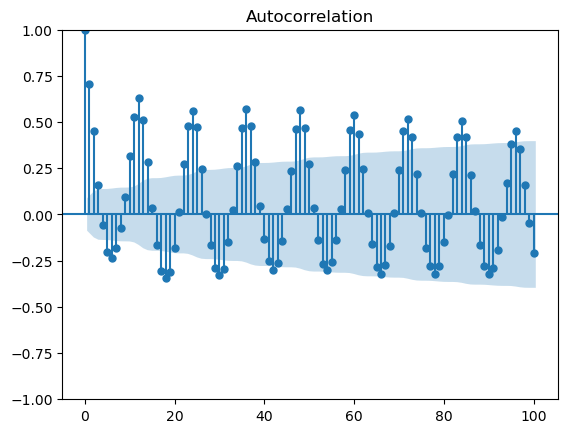

In [96]:
acf_values = plot_acf(series_monthly_mean_temp, lags=100)

##### Based on decaying ACF, we are likely dealing with an Auto Regressive process.

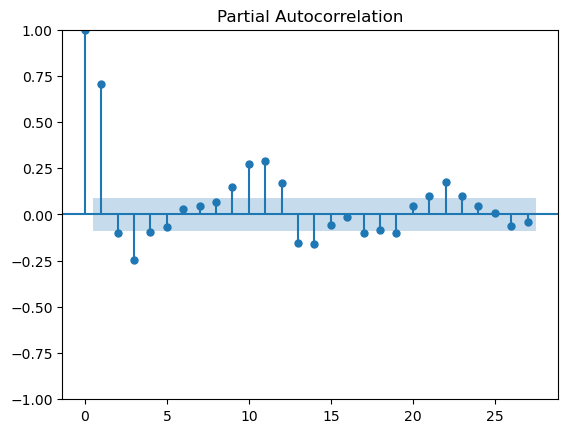

In [97]:
pacf_values = plot_pacf(series_monthly_mean_temp, method='ywm')

##### Based on decaying PACF, we are should start with an Auto Regressive model with lags 1, 3, 9, 10, 11, 12.

#### Augmented Dickey-Fuller Test

In [98]:
def perform_adf_test(series):
    result = adfuller(series)
    adf_statistic = result[0]
    p_value = result[1]
    print(f'ADF Statistic: {adf_statistic:.4f}')
    print(f'p-value: {p_value:.4f}')

perform_adf_test(series_monthly_mean_temp)

ADF Statistic: -4.4622
p-value: 0.0002


##### Since p-value < 0.5, time series is stationary.

### Model Validation

#### AR Model

In [105]:
# split 70:30 (28, 12)
train_end = datetime(2011, 1, 1) 
test_end = datetime(2023, 1, 1)

train_data = series_monthly_mean_temp[:train_end]
test_data = series_monthly_mean_temp[train_end + timedelta(days=1):test_end]

# create model
model = ARIMA(train_data, order=(12, 0, 0))

# fit model
start = time()
model_fit = model.fit()
end = time()
print(f"Model Fitting Time: {end - start}")

# summary of the model
print(model_fit.summary())

Model Fitting Time: 0.4866049289703369
                               SARIMAX Results                                
Dep. Variable:              mean_temp   No. Observations:                  348
Model:                ARIMA(12, 0, 0)   Log Likelihood                -236.362
Date:                Thu, 08 Jun 2023   AIC                            500.724
Time:                        20:25:25   BIC                            554.655
Sample:                    01-31-1982   HQIC                           522.195
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5814      0.156    176.262      0.000      27.275      27.888
ar.L1          0.5915      0.050     11.899      0.000       0.494       0.689
ar.L2        

##### We should only keep those lags with p-value < 0.5.

In [106]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

# get predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

# print(residuals)

# Plot residuals
fig_resid = px.line(residuals, labels={residuals.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from AR Model')
fig_resid.update_xaxes(dtick='M12', tickangle=45)
fig_resid.update_yaxes(dtick=0.5, tickangle=45)
fig_resid.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')

# add the mean line
mean_error = np.mean(residuals)
fig_resid.add_shape(
    type="line",
    x0=residuals.index[0],
    y0=mean_error,
    x1=residuals.index[-1],
    y1=mean_error,
    line=dict(color="red", dash="dot"),
)
fig_resid.show()

##### Clear pattern in residual data - means that there's some dynamic data that is failed to be captured i.e. not good.

In [107]:
plot_data = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions})
# print(plot_data)
fig_pred_test = px.line(plot_data, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions')
fig_pred_test.update_xaxes(dtick='M12', tickangle=45)
fig_pred_test.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals**2))}")

Mean Absolute Percent Error: 0.0215
Root Mean Squared Error: 0.7288853463855004


##### AR(3) Model:
Mean Absolute Percent Error: 0.0242
Root Mean Squared Error: 0.8109909048888814

##### AR(12) Model:
Mean Absolute Percent Error: 0.0215
Root Mean Squared Error: 0.7288853463855004

##### AR(12) did better than AR(3) here, as predicted by the lags of the PACF. Also, we can see that the further we predict into the future, the worst the predictions.

#### Rolling Forecast Origin (Rolling Window)

##### Predict 1 month in advance each time:

Train on months 1, 2, ..., k - 3 -> predict month k - 2

Train on months 1, 2, ..., k - 3, k - 2 -> predict month k - 1

Train on months 1, 2, ..., k - 3, k - 2, k - 1 -> predict month k

...

##### Average all predictions

In [110]:
# create the model
predictions_rolling = pd.Series(dtype='float64')
start = time()
for end_date in test_data.index:
    train_data = series_monthly_mean_temp[:end_date - timedelta(days=1)]
    model = ARIMA(train_data, order=(12, 0, 0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]
end = time()
print(f"Model Fitting Time: {end - start}")
residuals_rolling = test_data - predictions_rolling

# print(residuals_rolling)

# Plot residuals
fig_resid_rolling = px.line(residuals_rolling, labels={residuals_rolling.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from AR Model (Rolling Window)')
fig_resid_rolling.update_xaxes(dtick='M12', tickangle=45)
fig_resid_rolling.update_yaxes(dtick=0.5, tickangle=45)
fig_resid_rolling.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')

# add the mean line
mean_error_rolling = np.mean(residuals_rolling)
fig_resid_rolling.add_shape(
    type="line",
    x0=residuals_rolling.index[0],
    y0=mean_error_rolling,
    x1=residuals_rolling.index[-1],
    y1=mean_error_rolling,
    line=dict(color="red", dash="dot"),
)
fig_resid_rolling.show()

Model Fitting Time: 72.70002675056458


##### Although there is volatility in residual data, there is less pattern compared to just training on the test data in one shot (as shown above), means predictions will be closer and model is better.

In [111]:
plot_data_rolling = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions_rolling})
# print(plot_data)
fig_pred_test_rolling = px.line(plot_data_rolling, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions (Rolling Window)')
fig_pred_test_rolling.update_xaxes(dtick='M12', tickangle=45)
fig_pred_test_rolling.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test_rolling.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test_rolling.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals_rolling/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals_rolling**2))}")

Mean Absolute Percent Error: 0.0139
Root Mean Squared Error: 0.4852945337116935


##### AR(3) Model (Rolling Window):
Mean Absolute Percent Error: 0.0158
Root Mean Squared Error: 0.5362938714312385

##### AR(12) Model (Rolling Window):
Mean Absolute Percent Error: 0.0139
Root Mean Squared Error: 0.4852945337116935

##### As shown here, the RMSE of rolling window (0.48529) is lower than that of the non-rolling window (0.72889) of AR(12), and it predicts a better shape as it predicts in 1 month intervals of the test data consecutively rather than predicting over the whole test data. The downside is that rolling window takes a much longer time to train.

#### MA Model

Using ACF, we can know which lag/order to use for the MA model.

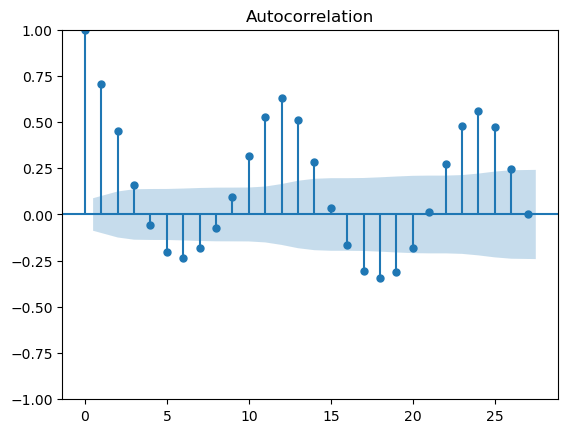

In [112]:
acf_values = plot_acf(series_monthly_mean_temp)

##### Based on decaying ACF, we should start with a Moving Average model with lags 1, 2 (for simplicity).

In [113]:
# split 70:30 (28, 12)
train_end = datetime(2011, 1, 1) 
test_end = datetime(2023, 1, 1)

train_data = series_monthly_mean_temp[:train_end]
test_data = series_monthly_mean_temp[train_end + timedelta(days=1):test_end]

# create model
model = ARIMA(train_data, order=(0, 0, 2))

# fit model
start = time()
model_fit = model.fit()
end = time()
print(f"Model Fitting Time: {end - start}")

# summary of the model
print(model_fit.summary())

Model Fitting Time: 0.0760040283203125
                               SARIMAX Results                                
Dep. Variable:              mean_temp   No. Observations:                  348
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -298.502
Date:                Thu, 08 Jun 2023   AIC                            605.004
Time:                        20:29:02   BIC                            620.413
Sample:                    01-31-1982   HQIC                           611.139
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5641      0.065    423.368      0.000      27.437      27.692
ma.L1          0.7289      0.052     14.098      0.000       0.628       0.830
ma.L2        

From the constants and the lag terms, we should use the predicted model:

##### ŷ(t) = 28 + 0.73ε(t-1) + 0.40ε(t-2) (ignore ε(t) as current prediction error is caught on the fly)

In this equation:

ŷ(t) represents the predicted value of the dependent variable at time t.
ε(t-1) represents the prediction error (residual) at time (t-1).
ε(t-2) represents the prediction error (residual) at time (t-2).
The coefficients 0.73 and 0.40 represent the weights assigned to the lagged prediction errors (ε).

In [114]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

# get predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

# print(residuals)

# Plot residuals
fig_resid = px.line(residuals, labels={residuals.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from MA Model')
fig_resid.update_xaxes(dtick='M12', tickangle=45)
fig_resid.update_yaxes(dtick=0.5, tickangle=45)
fig_resid.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')

# add the mean line
mean_error = np.mean(residuals)
fig_resid.add_shape(
    type="line",
    x0=residuals.index[0],
    y0=mean_error,
    x1=residuals.index[-1],
    y1=mean_error,
    line=dict(color="red", dash="dot"),
)
fig_resid.show()

##### Similar to the AR model above (without rolling window), clear pattern in residual data - means that there's some dynamic data that is failed to be captured i.e. not good.

In [115]:
plot_data = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions})
# print(plot_data)
fig_pred_test = px.line(plot_data, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions')
fig_pred_test.update_xaxes(dtick='M12', tickangle=45)
fig_pred_test.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals**2))}")

Mean Absolute Percent Error: 0.0243
Root Mean Squared Error: 0.813192975445521


##### As we used MA(2) of 2 lag periods, we could only predict the first 2 months of the test data. The MA model will then predict the rest of the test data as the mean value as shown above. This is a characteristic of the MA model.

##### For simplicity, we will omit the rolling window version of the MA model.

##### AR model uses PACF whereas MA model uses ACF.

#### ARMA Model

Although the above Augmented Dickey-Fuller Test showed a low p-value implying that the series might be stationary, we cannot be too sure as it seems as if there is a slight upward trend (possibly due to global warming) by just looking at the graph. To confirm, let's perform the first difference to check for stationarity. We can see the difference easier by comparing both graphs as shown below.

In [116]:
fig_monthly_mean_temp.show() # for easier comparison

first_diff = series_monthly_mean_temp.diff()[1:]
print(first_diff)

# line plot for mean temperature
fig_first_diff = px.line(first_diff, labels={first_diff.index.name: 'Datetime', 'value': 'Mean Temperature (°C)'}, title='First Difference of Monthly Mean Temperature')
fig_first_diff.update_xaxes(dtick='M12', tickangle=45)
fig_first_diff.update_yaxes(dtick=0.5, tickangle=45)
fig_first_diff.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')

# add the mean line
mean_temperature = np.mean(first_diff)
fig_first_diff.add_shape(
    type="line",
    x0=first_diff.index[0],
    y0=mean_temperature,
    x1=first_diff.index[-1],
    y1=mean_temperature,
    line=dict(color="red", dash="dot"),
)
fig_first_diff.show()

datetime
1982-02-28    1.2
1982-03-31    0.1
1982-04-30   -0.2
1982-05-31    1.0
1982-06-30    0.4
             ... 
2022-12-31   -0.6
2023-01-31   -0.3
2023-02-28    0.4
2023-03-31    0.2
2023-04-30    1.4
Freq: M, Name: mean_temp, Length: 495, dtype: float64


##### As the differenced series appears to be more stationary, it suggests that the original series had some form of trend or seasonality that was removed, in so doing, the data is preprocessed.

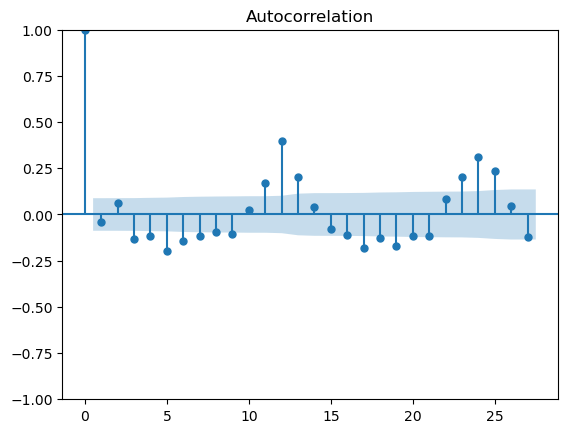

In [117]:
acf_values = plot_acf(first_diff)

##### Based on decaying ACF, we are should start with a MA process of order 12.

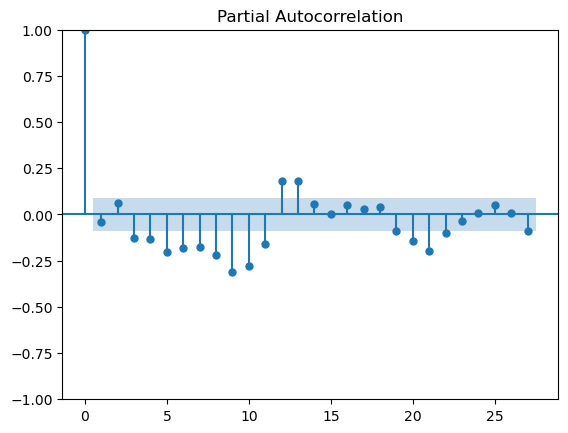

In [118]:
pacf_values = plot_pacf(first_diff, method='ywm')

##### Based on decaying PACF, we are should start with a AR process of order 9.

##### From here on, our test data will only consist of 1 year as it takes very long to fit the model with higher order processes, especially with the Rolling Forecast Origin.

In [119]:
# split to test 1 year of data as splitting 70:30 takes very long
train_end = datetime(2022, 1, 1) 
test_end = datetime(2023, 1, 1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

# create model
model = ARIMA(train_data, order=(9, 0, 12))

# fit model
start = time()
model_fit = model.fit()
end = time()
print(f"Model Fitting Time: {end - start}")

# summary of the model
print(model_fit.summary())

Model Fitting Time: 2.6048777103424072
                               SARIMAX Results                                
Dep. Variable:              mean_temp   No. Observations:                  479
Model:                ARIMA(9, 0, 12)   Log Likelihood                -287.025
Date:                Thu, 08 Jun 2023   AIC                            620.050
Time:                        20:29:21   BIC                            715.999
Sample:                    02-28-1982   HQIC                           657.768
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.005      0.432      0.666      -0.008       0.012
ar.L1         -0.2740      0.168     -1.633      0.103      -0.603       0.055
ar.L2        

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [120]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

# get predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

# print(residuals)

# Plot residuals
fig_resid = px.line(residuals, labels={residuals.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from ARMA Model')
fig_resid.update_xaxes(dtick='M1', tickangle=45)
fig_resid.update_yaxes(dtick=0.5, tickangle=45)
fig_resid.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')

# add the mean line
mean_error = np.mean(residuals)
fig_resid.add_shape(
    type="line",
    x0=residuals.index[0],
    y0=mean_error,
    x1=residuals.index[-1],
    y1=mean_error,
    line=dict(color="red", dash="dot"),
)
fig_resid.show()

In [121]:
plot_data = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions})
# print(plot_data)
fig_pred_test = px.line(plot_data, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'First Difference of Mean Temperature (°C)'}, title='Test Data and Predictions')
fig_pred_test.update_xaxes(dtick='M1', tickangle=45)
fig_pred_test.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test.update_traces(hovertemplate='Datetime: %{x}<br>First Difference of Mean Temperature: %{y}°C')
fig_pred_test.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals**2))}")

Mean Absolute Percent Error: inf
Root Mean Squared Error: 0.5841389478876554


##### Not very good, still has room for improvement. 

#### ARIMA Model

##### Now, let's use the I component (Integrated) to account for the first difference. Like before, we first analyse the ACF and PACF.

In [122]:
first_diff = series_monthly_mean_temp.diff()[1:]
# print(first_diff)

# line plot for mean temperature
fig_first_diff = px.line(first_diff, labels={first_diff.index.name: 'Datetime', 'value': 'Mean Temperature (°C)'}, title='First Difference of Monthly Mean Temperature')
fig_first_diff.update_xaxes(dtick='M12', tickangle=45)
fig_first_diff.update_yaxes(dtick=0.5, tickangle=45)
fig_first_diff.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')

# add the mean line
mean_temperature = np.mean(first_diff)
fig_first_diff.add_shape(
    type="line",
    x0=first_diff.index[0],
    y0=mean_temperature,
    x1=first_diff.index[-1],
    y1=mean_temperature,
    line=dict(color="red", dash="dot"),
)
fig_first_diff.show()

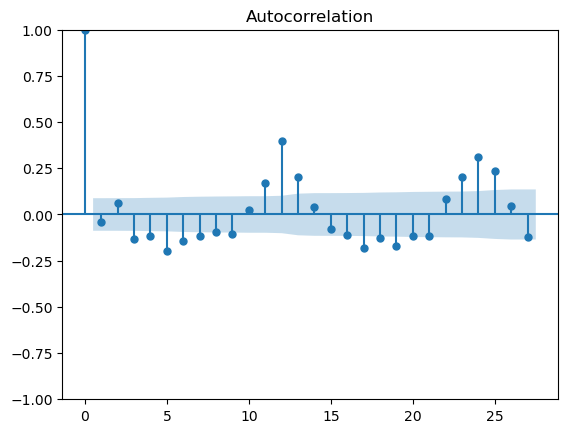

In [123]:
acf_values = plot_acf(first_diff)

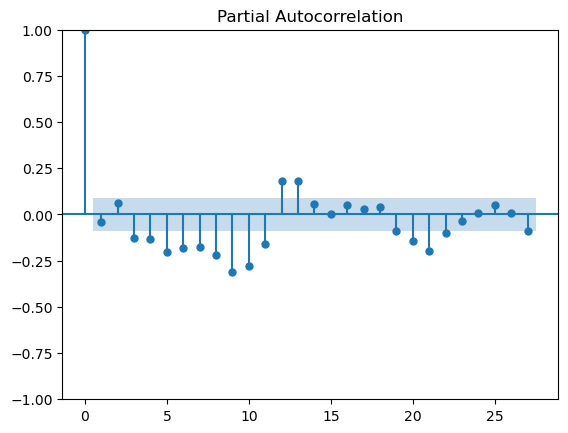

In [124]:
pacf_values = plot_pacf(first_diff, method='ywm')

In [125]:
# split to test 1 year of data as splitting 70:30 takes very long
train_end = datetime(2022, 1, 1) 
test_end = datetime(2023, 1, 1)

train_data = series_monthly_mean_temp[:train_end]
test_data = series_monthly_mean_temp[train_end + timedelta(days=1):test_end]

# create model
model = ARIMA(train_data, order=(9, 1, 12)) # (p, d, q) here we use d as 1 as we only performed 1 difference to make the series stationary.

# fit model
start = time()
model_fit = model.fit()
end = time()
print(f"Model Fitting Time: {end - start}")

# summary of the model
print(model_fit.summary())

Model Fitting Time: 2.488986015319824
                               SARIMAX Results                                
Dep. Variable:              mean_temp   No. Observations:                  480
Model:                ARIMA(9, 1, 12)   Log Likelihood                -285.269
Date:                Thu, 08 Jun 2023   AIC                            614.538
Time:                        20:29:32   BIC                            706.316
Sample:                    01-31-1982   HQIC                           650.617
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4575      0.117     -3.923      0.000      -0.686      -0.229
ar.L2         -0.2523      0.091     -2.759      0.006      -0.431      -0.073
ar.L3         

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [126]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

# get predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

# print(residuals)

# Plot residuals
fig_resid = px.line(residuals, labels={residuals.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from ARIMA Model')
fig_resid.update_xaxes(dtick='M1', tickangle=45)
fig_resid.update_yaxes(dtick=0.5, tickangle=45)
fig_resid.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')

# add the mean line
mean_error = np.mean(residuals)
fig_resid.add_shape(
    type="line",
    x0=residuals.index[0],
    y0=mean_error,
    x1=residuals.index[-1],
    y1=mean_error,
    line=dict(color="red", dash="dot"),
)
fig_resid.show()

In [127]:
plot_data = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions})
# print(plot_data)
fig_pred_test = px.line(plot_data, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions')
fig_pred_test.update_xaxes(dtick='M1', tickangle=45)
fig_pred_test.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals**2))}")

Mean Absolute Percent Error: 0.0109
Root Mean Squared Error: 0.40002647470247793


##### Compared to using just the ARMA model with first difference performed, with both AR(9) and MA(12), the ARIMA model performed better, having a RMSE (0.40003), lower than that of the ARMA model (0.58414).

##### Let's try to improve it using the rolling forecast origin.

In [128]:
# create the model
predictions_rolling = pd.Series(dtype='float64')
start = time()
for end_date in test_data.index:
    train_data = series_monthly_mean_temp[:end_date - timedelta(days=1)]
    model = ARIMA(train_data, order=(9, 1, 12)) # (p, d, q) here we use d as 1 as we are taking into account the first difference to mitigate the slight upward trend.
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]
end = time()
print(f"Model Fitting Time: {end - start}")
residuals_rolling = test_data - predictions_rolling

# print(residuals_rolling)

# Plot residuals
fig_resid_rolling = px.line(residuals_rolling, labels={residuals_rolling.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from ARIMA Model (Rolling Window)')
fig_resid_rolling.update_xaxes(dtick='M1', tickangle=45)
fig_resid_rolling.update_yaxes(dtick=0.5, tickangle=45)
fig_resid_rolling.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')

# add the mean line
mean_error_rolling = np.mean(residuals_rolling)
fig_resid_rolling.add_shape(
    type="line",
    x0=residuals_rolling.index[0],
    y0=mean_error_rolling,
    x1=residuals_rolling.index[-1],
    y1=mean_error_rolling,
    line=dict(color="red", dash="dot"),
)
fig_resid_rolling.show()

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarnin

Model Fitting Time: 29.885125160217285


/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [129]:
plot_data_rolling = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions_rolling})
# print(plot_data)
fig_pred_test_rolling = px.line(plot_data_rolling, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions (Rolling Window)')
fig_pred_test_rolling.update_xaxes(dtick='M1', tickangle=45)
fig_pred_test_rolling.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test_rolling.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test_rolling.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals_rolling/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals_rolling**2))}")

Mean Absolute Percent Error: 0.0113
Root Mean Squared Error: 0.4101693694305862


##### Here although it seems like the rolling forecast origin of the ARIMA model predicted values that had a closer shape following that of the test data, it has a slightly higher RMSE (0.41017) compared to the non-rolling version (0.40003). It seems that the rolling forecast origin is less effective when predicting over a short time period. It took quite a while to fit the model, even though we reduced our test data to just 1 year. This is probably due to the higher orders or AR and MA that we used.

#### SARIMA Model

##### Let's start by performing the first difference to remove the upward trend.

In [130]:
# fig_monthly_mean_temp.show() # for easier comparison

first_diff = series_monthly_mean_temp.diff()[1:]
# print(first_diff)

# line plot for mean temperature
fig_first_diff = px.line(first_diff, labels={first_diff.index.name: 'Datetime', 'value': 'Mean Temperature (°C)'}, title='First Difference of Monthly Mean Temperature')
fig_first_diff.update_xaxes(dtick='M12', tickangle=45)
fig_first_diff.update_yaxes(dtick=0.5, tickangle=45)
fig_first_diff.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')

# add the mean line
mean_temperature = np.mean(first_diff)
fig_first_diff.add_shape(
    type="line",
    x0=first_diff.index[0],
    y0=mean_temperature,
    x1=first_diff.index[-1],
    y1=mean_temperature,
    line=dict(color="red", dash="dot"),
)
fig_first_diff.show()

##### By zooming into the above graph, although we removed the upward trend, seasonality can still be observed, just like the original graph. Hence, lets perform a seasonal difference of 12 months, since we can observe the seasonality within every 12 months.

In [131]:
# Perform seasonal differencing
seasonal_diff = first_diff.diff(12)[12:]
# print(seasonal_diff)

# Line plot for seasonal difference of mean temperature
fig_seasonal_diff = px.line(seasonal_diff, labels={seasonal_diff.index.name: 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Seasonal Difference (+ First Difference) of Monthly Mean Temperature')
fig_seasonal_diff.update_xaxes(dtick='M12', tickangle=45)
fig_seasonal_diff.update_yaxes(dtick=0.5, tickangle=45)
fig_seasonal_diff.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')

# Add the mean line
mean_temperature = np.mean(seasonal_diff)
fig_seasonal_diff.add_shape(
    type="line",
    x0=seasonal_diff.index[0],
    y0=mean_temperature,
    x1=seasonal_diff.index[-1],
    y1=mean_temperature,
    line=dict(color="red", dash="dot"),
)
fig_seasonal_diff.show()

##### Great, now it's hard to observe seasonality. Now we have a time series that is probably stationary.

Requirements for having a stationary time series:
1. Constant mean: The mean of the time series remains constant over time. This means that the average value of the series does not change as time progresses.

2. Constant variance: The variance (or standard deviation) of the time series remains constant over time. This implies that the spread or dispersion of the data points does not change.

3. No seasonality: There is no systematic pattern or periodic fluctuations observed in the series. Seasonality refers to regular and predictable variations that occur at specific intervals, such as daily, weekly, or yearly patterns.

4. No trend: The series does not exhibit a long-term increasing or decreasing pattern. A trend represents a gradual change in the mean or level of the series over an extended period.

##### Now we analyse its ACF and PACF.

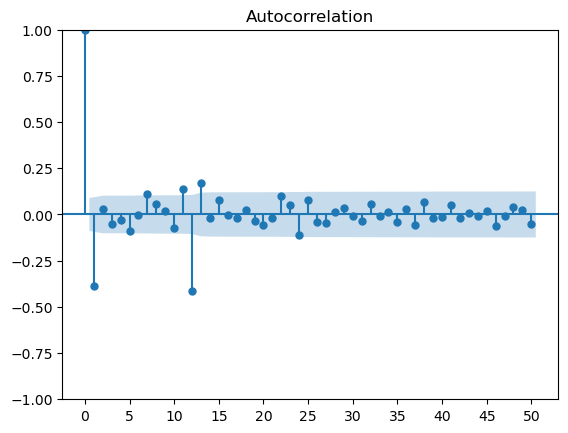

In [132]:
acf_values = plot_acf(seasonal_diff, lags=50)
plt.xticks(range(0, 51, 5))
plt.show()

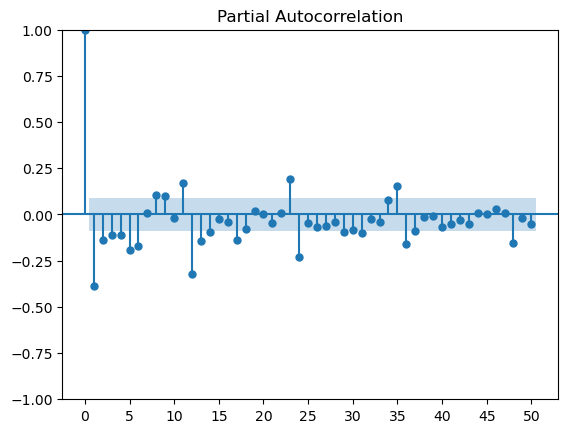

In [133]:
pacf_values = plot_pacf(seasonal_diff, lags=50, method='ywm')
plt.xticks(range(0, 51, 5))
plt.show()

##### As shown above, there are significant spikes in the ACF plot at lag 1 and 12. In the PACF plot, there is a significant spike at lag 1 and there are significant spikes at intervals of 12 lags. Since we performed a first difference of the original data, d=1 of the normal order, and since we also performed a seasonal difference, D=1 of the seasonal order. Due to the significant spikes at lag 1 of both the ACF and PACF, these are non-seasonal lags, therefore we can set p=1 and q=1 of the normal order. Due to the spikes at lag 12 of both the ACF and PACF, we can set P=1 and Q=1 (since the seasonal lag is 12 months)of the seasonal order. Last but not least, since the seasonal lag happens every 12 months, m=12 of the seasonal order. These characteristics suggest a potential parameter starting point of SARIMA(1,1,1)x(1,1,1,12).

In [134]:
# split to test 1 year of data as splitting 70:30 takes very long
train_end = datetime(2022, 1, 1) 
test_end = datetime(2023, 1, 1)

train_data = series_monthly_mean_temp[:train_end]
test_data = series_monthly_mean_temp[train_end + timedelta(days=1):test_end]

# create model
normal_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)
model = ARIMA(train_data, order=normal_order, seasonal_order=seasonal_order) 

# fit model
start = time()
model_fit = model.fit()
end = time()
print(f"Model Fitting Time: {end - start}")

# summary of the model
print(model_fit.summary())

Model Fitting Time: 1.8197648525238037
                                    SARIMAX Results                                     
Dep. Variable:                        mean_temp   No. Observations:                  480
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -277.962
Date:                          Thu, 08 Jun 2023   AIC                            565.924
Time:                                  20:32:57   BIC                            586.655
Sample:                              01-31-1982   HQIC                           574.082
                                   - 12-31-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1856      0.067      2.752      0.006       0.053       0.318
ma.L1       

##### From the model summary, we can see that there is a high p-value (>0.5) for the seasonal AR component, so it seems redundant and that there is some discrepancy that we have not accounted for. Note: I used `model = SARIMAX(train_data, order=normal_order, seasonal_order=seasonal_order) ` and there was no difference in result. Seems like the ARIMA function can apply the SARIMA model as well.

In [135]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

# get predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

# print(residuals)

# Plot residuals
fig_resid = px.line(residuals, labels={residuals.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from SARIMA Model')
fig_resid.update_xaxes(dtick='M1', tickangle=45)
fig_resid.update_yaxes(dtick=0.5, tickangle=45)
fig_resid.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')

# add the mean line
mean_error = np.mean(residuals)
fig_resid.add_shape(
    type="line",
    x0=residuals.index[0],
    y0=mean_error,
    x1=residuals.index[-1],
    y1=mean_error,
    line=dict(color="red", dash="dot"),
)
fig_resid.show()

In [136]:
plot_data = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions})
# print(plot_data)
fig_pred_test = px.line(plot_data, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions')
fig_pred_test.update_xaxes(dtick='M1', tickangle=45)
fig_pred_test.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals**2))}")

Mean Absolute Percent Error: 0.0155
Root Mean Squared Error: 0.5200608882024743


##### Seems like our SARIMA model performed worse than our ARIMA model (RMSE=0.40003). Let's try applying the rolling forecast origin.

In [137]:
normal_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# create the model
predictions_rolling = pd.Series(dtype='float64')
start = time()
for end_date in test_data.index:
    train_data = series_monthly_mean_temp[:end_date - timedelta(days=1)]
    model = ARIMA(train_data, order=normal_order, seasonal_order=seasonal_order) 
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]
end = time()
print(f"Model Fitting Time: {end - start}")
residuals_rolling = test_data - predictions_rolling

# print(residuals_rolling)

# Plot residuals
fig_resid_rolling = px.line(residuals_rolling, labels={residuals_rolling.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from SARIMA Model (Rolling Window)')
fig_resid_rolling.update_xaxes(dtick='M1', tickangle=45)
fig_resid_rolling.update_yaxes(dtick=0.5, tickangle=45)
fig_resid_rolling.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')

# add the mean line
mean_error_rolling = np.mean(residuals_rolling)
fig_resid_rolling.add_shape(
    type="line",
    x0=residuals_rolling.index[0],
    y0=mean_error_rolling,
    x1=residuals_rolling.index[-1],
    y1=mean_error_rolling,
    line=dict(color="red", dash="dot"),
)
fig_resid_rolling.show()

Model Fitting Time: 14.356170177459717


In [138]:
plot_data_rolling = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions_rolling})
# print(plot_data)
fig_pred_test_rolling = px.line(plot_data_rolling, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions (Rolling Window)')
fig_pred_test_rolling.update_xaxes(dtick='M1', tickangle=45)
fig_pred_test_rolling.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test_rolling.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test_rolling.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals_rolling/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals_rolling**2))}")

Mean Absolute Percent Error: 0.0123
Root Mean Squared Error: 0.43694862169817994


##### We can see that the rolling forecast origin on the SARIMA model did better, but it still fell short to the ARIMA model (rolling window RMSE=0.41017 and non-rolling RMSE=0.40003). Perhaps, the orders chosen were not the best or the SARIMA overfitted to a greater extent.

### Model Refinement: Automated Parameter Selection with `auto_arima`

To automate the process of parameter selection in time series modeling, we can use the `auto_arima` function provided by the `pmdarima` library. These functions use a combination of algorithms and heuristics to find the best set of parameters for the ARIMA and SARIMA models, respectively.

#### Auto ARIMA

The `auto_arima` function can be used to automatically determine the optimal parameters for an ARIMA model. It considers various combinations of p, d, and q values and evaluates the models based on the AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion). 

The AIC and BIC are based on the principle of trade-off between goodness of fit and model complexity. The goal is to find a model that fits the data well but is not overly complex, as overly complex models can lead to overfitting.

The AIC is defined as:

AIC = -2 * log-likelihood + 2 * k,

where log-likelihood is a measure of how well the model fits the data, and k is the number of parameters in the model. The AIC penalizes models with a larger number of parameters, meaning that models with a higher AIC value are considered less favorable.

The BIC is similar to the AIC but includes a stronger penalty for model complexity. It is defined as:

BIC = -2 * log-likelihood + k * log(n),

where n is the number of observations in the data. The BIC penalizes models with a larger number of parameters more severely than the AIC, leading to a more conservative model selection.

In [143]:
# split to test 1 year of data as splitting 70:30 takes very long
train_end = datetime(2022, 1, 1) 
test_end = datetime(2023, 1, 1)

train_data = series_monthly_mean_temp[:train_end]
test_data = series_monthly_mean_temp[train_end + timedelta(days=1):test_end]

# Find optimal ARIMA order using auto_arima
model_arima = auto_arima(series_monthly_mean_temp, d=0, max_d=3, max_p=12, max_q=12, max_order=24, parallel=True, num_cores=None, seasonal=False, information_criterion='aic', trace=True, stepwise=False)

# Get the best ARIMA order
order_arima = model_arima.order

print("Optimal ARIMA order:", order_arima)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4703.909, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4044.152, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3447.842, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3012.063, Time=0.38 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2644.616, Time=0.47 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=2373.222, Time=0.31 sec
 ARIMA(0,0,6)(0,0,0)[0]             : AIC=2168.781, Time=0.66 sec
 ARIMA(0,0,7)(0,0,0)[0]             : AIC=inf, Time=1.26 sec
 ARIMA(0,0,8)(0,0,0)[0]             : AIC=inf, Time=2.09 sec
 ARIMA(0,0,9)(0,0,0)[0]             : AIC=inf, Time=1.42 sec
 ARIMA(0,0,10)(0,0,0)[0]             : AIC=inf, Time=2.86 sec
 ARIMA(0,0,11)(0,0,0)[0]             : AIC=1578.521, Time=1.24 sec
 ARIMA(0,0,12)(0,0,0)[0]             : AIC=inf, Time=2.76 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=923.908, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : 

In [144]:
# create model
model = ARIMA(train_data, order=order_arima)

# fit model
start = time()
model_fit = model.fit()
end = time()
print(f"Model Fitting Time: {end - start}")

# Print model summary
print(model_fit.summary())

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Model Fitting Time: 7.549797058105469
                               SARIMAX Results                                
Dep. Variable:              mean_temp   No. Observations:                  480
Model:                ARIMA(12, 0, 8)   Log Likelihood                -284.550
Date:                Thu, 08 Jun 2023   AIC                            613.099
Time:                        20:56:00   BIC                            704.923
Sample:                    01-31-1982   HQIC                           649.193
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.6671      0.151    183.394      0.000      27.371      27.963
ar.L1          0.2012      0.200      1.005      0.315      -0.191       0.594
ar.L2         

In [145]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

# get predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

# print(residuals)

# Plot residuals
fig_resid = px.line(residuals, labels={residuals.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from auto ARIMA Model')
fig_resid.update_xaxes(dtick='M1', tickangle=45)
fig_resid.update_yaxes(dtick=0.5, tickangle=45)
fig_resid.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')

# add the mean line
mean_error = np.mean(residuals)
fig_resid.add_shape(
    type="line",
    x0=residuals.index[0],
    y0=mean_error,
    x1=residuals.index[-1],
    y1=mean_error,
    line=dict(color="red", dash="dot"),
)
fig_resid.show()

In [146]:
plot_data = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions})
# print(plot_data)
fig_pred_test = px.line(plot_data, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions')
fig_pred_test.update_xaxes(dtick='M1', tickangle=45)
fig_pred_test.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals**2))}")

Mean Absolute Percent Error: 0.0116
Root Mean Squared Error: 0.37387541794493334


##### ARIMA(12,0,8)(0,0,0)[0]:
Mean Absolute Percent Error: 0.0116
Root Mean Squared Error: 0.37387541794493334

##### ARIMA(9,1,9)(0,0,0)[0]:
Mean Absolute Percent Error: 0.0136
Root Mean Squared Error: 0.45632291182559315

The auto ARIMA chose the above 2 orders as the optimal orders, as I tried with different orders of _d_. Weirdly enough, the ARIMA without first differencing performed better than with first differencing. This shows that differencing is not always necessary or beneficial, or maybe the chosen _p_ and _q_ were not optimal.

##### Since ARIMA(12,0,8)(0,0,0)[0] did better here, let's try using RFO on ARIMA(12,0,8)(0,0,0)[0] to see if it improves the predictions.

In [147]:
# create the model
predictions_rolling = pd.Series(dtype='float64')
start = time()
for end_date in test_data.index:
    train_data = series_monthly_mean_temp[:end_date - timedelta(days=1)]
    model = ARIMA(train_data, order=(12, 0, 8))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]
end = time()
print(f"Model Fitting Time: {end - start}")
residuals_rolling = test_data - predictions_rolling

# print(residuals_rolling)

# Plot residuals
fig_resid_rolling = px.line(residuals_rolling, labels={residuals_rolling.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from auto ARIMA Model (Rolling Window)')
fig_resid_rolling.update_xaxes(dtick='M1', tickangle=45)
fig_resid_rolling.update_yaxes(dtick=0.5, tickangle=45)
fig_resid_rolling.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')

# add the mean line
mean_error_rolling = np.mean(residuals_rolling)
fig_resid_rolling.add_shape(
    type="line",
    x0=residuals_rolling.index[0],
    y0=mean_error_rolling,
    x1=residuals_rolling.index[-1],
    y1=mean_error_rolling,
    line=dict(color="red", dash="dot"),
)
fig_resid_rolling.show()

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-p

Model Fitting Time: 36.39222598075867


In [148]:
plot_data_rolling = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions_rolling})
# print(plot_data)
fig_pred_test_rolling = px.line(plot_data_rolling, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions (Rolling Window)')
fig_pred_test_rolling.update_xaxes(dtick='M1', tickangle=45)
fig_pred_test_rolling.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test_rolling.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test_rolling.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals_rolling/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals_rolling**2))}")

Mean Absolute Percent Error: 0.0114
Root Mean Squared Error: 0.40277785698754665


##### Seems like with RFO, the predictions are worse than without RFO (RMSE=0.37388). Initially I thought that RFO would always perform better but I noticed that this is not always the case, especially in this scenario, when the test data is limited to 1 year, as compared to the initial 70:30 split with test data consisting of 12 years. Perhaps there is a correlation between the sample size and the variability of the data. With a smaller test set (with the 39:1 split), the evaluation of the model's performance becomes more sensitive to individual data points, which can lead to more variability in the results. On the other hand, despite its RMSE being higher, the RFO version's graph has a shape closer to the test data, compared to the non-RFO version.

#### Auto SARIMA

In [158]:
# split to test 1 year of data as splitting 70:30 takes very long
train_end = datetime(2022, 1, 1) 
test_end = datetime(2023, 1, 1)

train_data = series_monthly_mean_temp[:train_end]
test_data = series_monthly_mean_temp[train_end + timedelta(days=1):test_end]

# Find optimal SARIMA order using auto_arima
model_sarima = auto_arima(series_monthly_mean_temp, d=1, max_d=3, max_D=3, max_p=12, max_q=12, max_P=1, max_Q=1, max_order=26, parallel=True, num_cores=None, seasonal=True, m=12, information_criterion='aic', trace=True, stepwise=False)

# Get the best SARIMA order
normal_order = model_sarima.order
seasonal_order = model_sarima.seasonal_order

print("Optimal SARIMA order:", normal_order)
print("Optimal SARIMA seasonal order:", seasonal_order)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=913.330, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=851.187, Time=0.12 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=827.111, Time=0.10 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=914.480, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=840.119, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=787.031, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=914.540, Time=0.09 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=842.027, Time=0.32 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=783.875, Time=0.38 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(0,1,3)(0,0,0)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,1,3)(0,0,1)[12] intercept   : AIC=inf, Time=2.18 sec
 ARIMA(0,1,3)(1,0,0)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,1,3)(1,0,1)[12] intercept

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning:

Error fitting  ARIMA(3,1,7)(1,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/pmdarima/arima/arim

 ARIMA(3,1,7)(1,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,1,8)(0,0,0)[12] intercept   : AIC=794.679, Time=1.96 sec
 ARIMA(3,1,8)(0,0,1)[12] intercept   : AIC=inf, Time=4.32 sec
 ARIMA(3,1,8)(1,0,0)[12] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(3,1,8)(1,0,1)[12] intercept   : AIC=inf, Time=5.11 sec
 ARIMA(3,1,9)(0,0,0)[12] intercept   : AIC=748.471, Time=1.61 sec
 ARIMA(3,1,9)(0,0,1)[12] intercept   : AIC=inf, Time=4.32 sec
 ARIMA(3,1,9)(1,0,0)[12] intercept   : AIC=inf, Time=2.98 sec
 ARIMA(3,1,9)(1,0,1)[12] intercept   : AIC=inf, Time=4.81 sec
 ARIMA(3,1,10)(0,0,0)[12] intercept   : AIC=763.290, Time=1.90 sec
 ARIMA(3,1,10)(0,0,1)[12] intercept   : AIC=749.514, Time=5.39 sec
 ARIMA(3,1,10)(1,0,0)[12] intercept   : AIC=732.901, Time=2.21 sec
 ARIMA(3,1,10)(1,0,1)[12] intercept   : AIC=692.967, Time=7.33 sec
 ARIMA(3,1,11)(0,0,0)[12] intercept   : AIC=760.981, Time=2.35 sec
 ARIMA(3,1,11)(0,0,1)[12] intercept   : AIC=725.232, Time=6.24 sec
 ARIMA(3,1,11)(1,0,0)[12] interce

In [159]:
# create model
model = ARIMA(train_data, order=normal_order, seasonal_order=seasonal_order)

# fit model
start = time()
model_fit = model.fit()
end = time()
print(f"Model Fitting Time: {end - start}")

# Print model summary
print(model_fit.summary())

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Model Fitting Time: 4.402470827102661
                                      SARIMAX Results                                      
Dep. Variable:                           mean_temp   No. Observations:                  480
Model:             ARIMA(11, 1, 6)x(0, 0, [1], 12)   Log Likelihood                -281.080
Date:                             Thu, 08 Jun 2023   AIC                            600.160
Time:                                     22:06:27   BIC                            679.422
Sample:                                 01-31-1982   HQIC                           631.319
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9615      0.025    -38.784      0.000      -1.010  

In [160]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

# get predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

# print(residuals)

# Plot residuals
fig_resid = px.line(residuals, labels={residuals.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from auto SARIMA Model')
fig_resid.update_xaxes(dtick='M1', tickangle=45)
fig_resid.update_yaxes(dtick=0.5, tickangle=45)
fig_resid.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')

# add the mean line
mean_error = np.mean(residuals)
fig_resid.add_shape(
    type="line",
    x0=residuals.index[0],
    y0=mean_error,
    x1=residuals.index[-1],
    y1=mean_error,
    line=dict(color="red", dash="dot"),
)
fig_resid.show()

In [161]:
plot_data = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions})
# print(plot_data)
fig_pred_test = px.line(plot_data, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions')
fig_pred_test.update_xaxes(dtick='M1', tickangle=45)
fig_pred_test.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals**2))}")

Mean Absolute Percent Error: 0.0104
Root Mean Squared Error: 0.34995830445205695


##### SARIMA(11,0,8)(0,0,0)[12]:
Mean Absolute Percent Error: 0.0165
Root Mean Squared Error: 0.6175906151774886

##### SARIMA(11,1,6)(0,0,1)[12]:
Mean Absolute Percent Error: 0.0104
Root Mean Squared Error: 0.34995830445205695

The auto SARIMA model chose these 2 optimal models with different orders of _d_. Here, SARIMA(11,1,6)(0,0,1)[12] was better, even better that that of ARIMA(12,0,8)(0,0,0)[0] (RMSE=0.37388). 

##### Let's complete this with the RFO of SARIMA(11,1,6)(0,0,1)[12].

In [162]:
# create the model
predictions_rolling = pd.Series(dtype='float64')
start = time()
for end_date in test_data.index:
    train_data = series_monthly_mean_temp[:end_date - timedelta(days=1)]
    model = ARIMA(train_data, order=(11, 1, 6), seasonal_order=(0, 0, 1, 12), enforce_stationarity=False)
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]
end = time()
print(f"Model Fitting Time: {end - start}")
residuals_rolling = test_data - predictions_rolling

# print(residuals_rolling)

# Plot residuals
fig_resid_rolling = px.line(residuals_rolling, labels={residuals_rolling.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from auto SARIMA Model (Rolling Window)')
fig_resid_rolling.update_xaxes(dtick='M1', tickangle=45)
fig_resid_rolling.update_yaxes(dtick=0.5, tickangle=45)
fig_resid_rolling.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')

# add the mean line
mean_error_rolling = np.mean(residuals_rolling)
fig_resid_rolling.add_shape(
    type="line",
    x0=residuals_rolling.index[0],
    y0=mean_error_rolling,
    x1=residuals_rolling.index[-1],
    y1=mean_error_rolling,
    line=dict(color="red", dash="dot"),
)
fig_resid_rolling.show()

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/linustws/opt/anaconda3/envs/singapore-weather-prediction/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarnin

Model Fitting Time: 39.012366771698


##### Note: I had to use enforce_stationarity=False here if not I would get a LinAlgError: LU decomposition error.

In [163]:
plot_data_rolling = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions_rolling})
# print(plot_data)
fig_pred_test_rolling = px.line(plot_data_rolling, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions (Rolling Window)')
fig_pred_test_rolling.update_xaxes(dtick='M1', tickangle=45)
fig_pred_test_rolling.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test_rolling.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test_rolling.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals_rolling/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals_rolling**2))}")

Mean Absolute Percent Error: 0.0116
Root Mean Squared Error: 0.40789190822712473


##### The RFO of SARIMA(11,1,6)(0,0,1)[12] did worse than its non RFO (RMSE=0.34996), similar to the RFO of ARIMA with the non-RFO ARIMA. Overall, looking at the above results, it seems that auto SARIMA and auto ARIMA performed about the same.</br>SARIMA(11,1,6)(0,0,1)[12]: 0.34996</br>SARIMA(11,1,6)(0,0,1)[12] RFO: 0.40789</br>ARIMA(12,0,8)(0,0,0)[0]: 0.37388</br>ARIMA(12,0,8)(0,0,0)[0] RFO: 0.40278

### Use LSTM model

In [8]:
fig_monthly_mean_temp.show()

In [18]:
# Perform seasonal decomposition (this can help analyse the individual components in greater detail)
results = seasonal_decompose(series_monthly_mean_temp)

# Plot the seasonal decomposition 
fig_decomposition = px.line(results.observed, title='Seasonal Decomposition - Observed')
fig_decomposition.update_xaxes(title='Datetime')
fig_decomposition.update_yaxes(title='Observed')
fig_decomposition.show()

In [19]:
fig_trend = px.line(results.trend, title='Seasonal Decomposition - Trend')
fig_trend.update_xaxes(title='Datetime')
fig_trend.update_yaxes(title='Trend')
fig_trend.show()

In [20]:
fig_seasonal = px.line(results.seasonal, title='Seasonal Decomposition - Seasonal')
fig_seasonal.update_xaxes(title='Datetime')
fig_seasonal.update_yaxes(title='Seasonal')
fig_seasonal.show()

In [21]:
fig_residual = px.line(results.resid, title='Seasonal Decomposition - Residual')
fig_residual.update_xaxes(title='Datetime')
fig_residual.update_yaxes(title='Residual')
fig_residual.show()

##### There is no need to make the data stationary here as RNN can work on more complex and non-stationary data compared to the ARIMA models.

In [217]:
# set seed to ensure determinism and reproduceability (always retest from here)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

# print(series_monthly_mean_temp)
df_monthly_mean_temp = series_monthly_mean_temp.to_frame()  # Convert Series to DataFrame
# print(df_monthly_mean_temp)
scaler = MinMaxScaler()
scaler.fit(df_monthly_mean_temp)
df_normalised_monthly_mean_temp = scaler.transform(df_monthly_mean_temp)
print(df_normalised_monthly_mean_temp.shape)

# Create a new DataFrame with the normalized values
df_normalised_monthly_mean_temp = pd.DataFrame(df_normalised_monthly_mean_temp, columns=['normalised'], index=df_monthly_mean_temp.index)
# print(df_normalised)
mean_normalised_monthly_mean_temp = df_normalised_monthly_mean_temp['normalised'].mean()

# Plot the normalized data
fig_normalised_monthly_mean_temp = px.line(df_normalised_monthly_mean_temp, labels={df_normalised_monthly_mean_temp.index.name: 'Datetime', 'value': 'Normalised'}, title='Normalised Mean Temperature')
fig_normalised_monthly_mean_temp.update_xaxes(dtick='M12', tickangle=45)
fig_normalised_monthly_mean_temp.update_yaxes(dtick=0.2, tickangle=45)
fig_normalised_monthly_mean_temp.update_traces(hovertemplate='Datetime: %{x}<br>Normalised Value: %{y}')

# add the mean line
fig_normalised_monthly_mean_temp.add_shape(
    type="line",
    x0=df_normalised_monthly_mean_temp.index[0],
    y0=mean_normalised_monthly_mean_temp,
    x1=df_normalised_monthly_mean_temp.index[-1],
    y1=mean_normalised_monthly_mean_temp,
    line=dict(color="red", dash="dot"),
)
fig_normalised_monthly_mean_temp.show()

(496, 1)


In [218]:
# split train:test to 80:20
train_end = int(len(df_normalised_monthly_mean_temp) * 0.8)
train_data = df_monthly_mean_temp[:train_end]
test_data = df_monthly_mean_temp[train_end:]
train_data_norm = df_normalised_monthly_mean_temp[:train_end].values
test_data_norm = df_normalised_monthly_mean_temp[train_end:].values

# print(train_data)
# print(test_data)
# print(train_data_norm.shape)
# print(test_data_norm.shape)

In [219]:
# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train_data_norm, train_data_norm, length=n_input, batch_size=1)

# Create the validation generator
validation_generator = TimeseriesGenerator(test_data_norm, test_data_norm, length=n_input, batch_size=1)

In [220]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y.flatten()}')
X.shape

Given the Array: 
[0.12195122 0.41463415 0.43902439 0.3902439  0.63414634 0.73170732
 0.68292683 0.56097561 0.6097561  0.48780488 0.46341463 0.19512195]
Predict this y: 
 [0.26829268]


(1, 12, 1)

In [221]:
# define model
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(n_input, n_features))) # here i used tanh instead of relu to take advantage of cuDNN to speed up training
# model.add(Dropout(0.2)) 
model.add(Dense(1))
# optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 100)               40800     
                                                                 
 dense_30 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [222]:
# fit model and save history
history = model.fit(generator,epochs=100, validation_data=validation_generator)

Epoch 1/100
384/384 [==============================] - 3s 4ms/step - loss: 0.0386 - val_loss: 0.0362
Epoch 2/100
384/384 [==============================] - 1s 4ms/step - loss: 0.0220 - val_loss: 0.0176
Epoch 3/100
384/384 [==============================] - 1s 4ms/step - loss: 0.0180 - val_loss: 0.0163
Epoch 4/100
384/384 [==============================] - 1s 4ms/step - loss: 0.0162 - val_loss: 0.0187
Epoch 5/100
384/384 [==============================] - 1s 4ms/step - loss: 0.0169 - val_loss: 0.0153
Epoch 6/100
384/384 [==============================] - 1s 4ms/step - loss: 0.0162 - val_loss: 0.0156
Epoch 7/100
384/384 [==============================] - 1s 4ms/step - loss: 0.0160 - val_loss: 0.0159
Epoch 8/100
384/384 [==============================] - 1s 3ms/step - loss: 0.0151 - val_loss: 0.0148
Epoch 9/100
384/384 [==============================] - 1s 4ms/step - loss: 0.0153 - val_loss: 0.0155
Epoch 10/100
384/384 [==============================] - 1s 4ms/step - loss: 0.0151 - val_lo

In [223]:
# Get loss history
loss = history.history['loss']
val_loss = history.history['val_loss']

# print(f"training loss: {loss}")
# print(f"validation loss: {val_loss}")

# Find the epoch with the minimum validation loss
min_val_loss_epoch = np.argmin(val_loss) + 1
min_val_loss = val_loss[min_val_loss_epoch - 1]

print(f"Minimum validation loss: {min_val_loss}")
print(f"Epoch with minimum validation loss: {min_val_loss_epoch}")

# Create DataFrame
epochs = range(1, len(loss) + 1)
loss_df = pd.DataFrame({'epoch': epochs, 'training_loss': loss, 'validation_loss': val_loss})

# Plot loss
fig_loss = px.line(loss_df, x='epoch', y=['training_loss', 'validation_loss'], labels={'value': 'Loss', 'epoch': 'Epoch'}, title='Training and Validation Loss')
fig_loss.update_xaxes(tickangle=45)
fig_loss.update_yaxes(tickangle=45)
fig_loss.update_traces(hovertemplate='Epoch: %{x}<br>Loss: %{y}')
fig_loss.show()

Minimum validation loss: 0.01386861503124237
Epoch with minimum validation loss: 96


In [224]:
last_train_batch = train_data_norm[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)


1/1 [==============================] - 0s 243ms/step


array([[0.3631621]], dtype=float32)

In [225]:
test_data_norm[0]

array([0.36585366])

In [ ]:
predictions_norm = []

first_eval_batch = train_data_norm[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    predictions_norm.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 19ms/step


In [213]:
predictions_norm

[array([0.3631621], dtype=float32),
 array([0.42597657], dtype=float32),
 array([0.55605394], dtype=float32),
 array([0.6863072], dtype=float32),
 array([0.76753056], dtype=float32),
 array([0.78265554], dtype=float32),
 array([0.7166672], dtype=float32),
 array([0.62514055], dtype=float32),
 array([0.58941144], dtype=float32),
 array([0.5960854], dtype=float32),
 array([0.46640316], dtype=float32),
 array([0.34995174], dtype=float32),
 array([0.3467129], dtype=float32),
 array([0.40914553], dtype=float32),
 array([0.5226751], dtype=float32),
 array([0.6477614], dtype=float32),
 array([0.7378394], dtype=float32),
 array([0.74744046], dtype=float32),
 array([0.6793829], dtype=float32),
 array([0.6173713], dtype=float32),
 array([0.60769844], dtype=float32),
 array([0.5679723], dtype=float32),
 array([0.43790647], dtype=float32),
 array([0.33309907], dtype=float32),
 array([0.34270018], dtype=float32),
 array([0.41882026], dtype=float32),
 array([0.53937066], dtype=float32),
 array([0.66

In [214]:
# print(type(df_normalised_monthly_mean_temp))
# print(type(test_data))
# print(test_data.shape)
# print(test_data[:5])
print(test_data.head())
predictions = scaler.inverse_transform(predictions_norm)

            mean_temp
datetime             
2015-01-31       26.9
2015-02-28       27.0
2015-03-31       28.2
2015-04-30       28.6
2015-05-31       28.7


In [215]:
residuals = test_data - predictions

# print(type(residuals))
# print(type(residuals))

# Plot residuals
fig_resid = px.line(residuals, labels={'datetime': 'Datetime', 'value': 'Error'}, title='Residuals from LSTM Model')
fig_resid.update_xaxes(dtick='M12', tickangle=45)
fig_resid.update_yaxes(dtick=0.5, tickangle=45)
fig_resid.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')

# add the mean line
mean_error = np.mean(residuals, axis=0)
# print(mean_error)
# print(type(mean_error))
fig_resid.add_shape(
    type="line",
    x0=residuals.index[0],
    y0=mean_error.values,
    x1=residuals.index[-1],
    y1=mean_error.values,
    line=dict(color="red", dash="dot"),
)
fig_resid.show()

In [216]:
# print(test_data_no_norm.index)

plot_data = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values.flatten(), 'predictions': predictions.flatten()})
# print(plot_data)
fig_pred_test = px.line(plot_data, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions')
fig_pred_test.update_xaxes(dtick='M12', tickangle=45)
fig_pred_test.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals/test_data), axis=0).item(), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals**2, axis=0)).item()}")

Mean Absolute Percent Error: 0.0177
Root Mean Squared Error: 0.6206300301271244


##### lr=0.001</br>No Dropout</br>90:10</br>LSTM(100 epochs):
Mean Absolute Percent Error: 0.0198
Root Mean Squared Error: 0.6755985619320392

##### LSTM(103 epochs, loss: 0.0085 - val_loss: 0.0119, beyond this point training loss decreases while validation loss fluctuates i.e. overfitting)
Mean Absolute Percent Error: 0.0215
Root Mean Squared Error: 0.7549385723557431

##### LSTM(200 epochs):
Mean Absolute Percent Error: 0.0213
Root Mean Squared Error: 0.7878989971160217

##### 80:20</br>LSTM(100 epochs):
Mean Absolute Percent Error: 0.0177
Root Mean Squared Error: 0.6206300301271244

##### LSTM(113 epochs, loss: 0.0077 - val_loss: 0.0134, beyond this point training loss decreases while validation loss fluctuates i.e. overfitting)
Mean Absolute Percent Error: 0.0191
Root Mean Squared Error: 0.6949460889739134

##### LSTM(200 epochs):
Mean Absolute Percent Error: 0.0173
Root Mean Squared Error: 0.6148360571951464

##### 70:30</br>LSTM(100 epochs):
Mean Absolute Percent Error: 0.0171
Root Mean Squared Error: 0.5935231394134313

##### LSTM(82 epochs, loss: 0.0101 - val_loss: 0.0121, beyond this point training loss decreases while validation loss fluctuates i.e. overfitting)
Mean Absolute Percent Error: 0.0194
Root Mean Squared Error: 0.7037250795707977

##### LSTM(200 epochs):
Mean Absolute Percent Error: 0.0177
Root Mean Squared Error: 0.6491459898664801

##### lr=0.001</br>Dropout=0.2</br>80:20</br>LSTM(100 epochs):
Mean Absolute Percent Error: 0.0249
Root Mean Squared Error: 0.8411129392339437

##### LSTM(200 epochs):
Mean Absolute Percent Error: 0.0294
Root Mean Squared Error: 1.0054840656823747

##### lr=0.01 (val_loss not decreasing aft a short while, overfitting)</br>No Dropout</br>80:20</br>LSTM(100 epochs):
Mean Absolute Percent Error: 0.0273
Root Mean Squared Error: 0.9110724662539238

##### LSTM(200 epochs):
Mean Absolute Percent Error: 0.0179
Root Mean Squared Error: 0.6357450427997889

##### lr=0.0001 (converges too slowly, underfittng)</br>No Dropout</br>80:20</br>LSTM(100 epochs):
Mean Absolute Percent Error: 0.0173
Root Mean Squared Error: 0.6130719319221452

##### LSTM(200 epochs):
Mean Absolute Percent Error: 0.027
Root Mean Squared Error: 0.9599652594001916

##### It seems that lr=0.001 is the best here, and having dropout regularisation of 0.2 worsened the model's performance, although I only tested it on 80:20 split with 100 and 200 epochs to save time.Also, I learnt that although using the minimum validation loss to find the best fit model (least under/overfitting) is viable, it does not necessarily imply it will have the lowest RMSE. Additionally, it seems that we should not overlook the proportion of the validation dataset. If it's too small, there may not be enough diverse samples to effectively evaluate the model's generalization performance. As a result, the model may become overly tuned to the training data and perform poorly on unseen data. This can lead to overfitting, where the model memorizes the training examples instead of learning the underlying patterns. Here I required more than a year of validation/test data due to the n_input = 12, thus I split that data into ratios instead of a static limit of 1 year as I did with the ARIMA models. I would have did this ratio splitting on the ARIMA models if it did not take so long to train on multiple years of test data but due to this limitation I restricted its test data to a year. 

##### It was at this point when I realised actually I don't need to split into training and validation sets. The validation set can be used during the training phase to monitor the model's performance on data that is closer to the present time. This can help in detecting overfitting or other issues that may arise during training. By evaluating the model's performance on the validation set, I can make adjustments to the model's architecture, hyperparameters, or training process to improve its generalization ability and overall performance. However, I felt that the entire data is relevant for training, as there is a slight upward trend for the mean temperature right from the start, thus splitting into training and validation might not fully capture this trend, thus I have decided to train uptil end of 2021 and predict on test data of 2022, just like the ARIMA models. I'll then assess the performance by comparing the RMSE values of the predictions. This way, I can make a fair judgement comparing LSTM and ARIMA as the train:test split ratio would be the same.

In [15]:
# set seed to ensure determinism and reproduceability (always retest from here)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

# print(series_monthly_mean_temp)
df_monthly_mean_temp = series_monthly_mean_temp.to_frame()  # Convert Series to DataFrame
# print(df_monthly_mean_temp)
scaler = MinMaxScaler()
scaler.fit(df_monthly_mean_temp)
df_normalised_monthly_mean_temp = scaler.transform(df_monthly_mean_temp)
print(df_normalised_monthly_mean_temp.shape)

# Create a new DataFrame with the normalized values
df_normalised_monthly_mean_temp = pd.DataFrame(df_normalised_monthly_mean_temp, columns=['normalised'], index=df_monthly_mean_temp.index)
# print(df_normalised)
mean_normalised_monthly_mean_temp = df_normalised_monthly_mean_temp['normalised'].mean()

# Plot the normalized data
fig_normalised_monthly_mean_temp = px.line(df_normalised_monthly_mean_temp, labels={df_normalised_monthly_mean_temp.index.name: 'Datetime', 'value': 'Normalised'}, title='Normalised Mean Temperature')
fig_normalised_monthly_mean_temp.update_xaxes(dtick='M12', tickangle=45)
fig_normalised_monthly_mean_temp.update_yaxes(dtick=0.2, tickangle=45)
fig_normalised_monthly_mean_temp.update_traces(hovertemplate='Datetime: %{x}<br>Normalised Value: %{y}')

# add the mean line
fig_normalised_monthly_mean_temp.add_shape(
    type="line",
    x0=df_normalised_monthly_mean_temp.index[0],
    y0=mean_normalised_monthly_mean_temp,
    x1=df_normalised_monthly_mean_temp.index[-1],
    y1=mean_normalised_monthly_mean_temp,
    line=dict(color="red", dash="dot"),
)
# fig_normalised_monthly_mean_temp.show()

# split to test 1 year of data as splitting 70:30 takes very long
train_end = datetime(2022, 1, 1) 
test_end = datetime(2023, 1, 1)
train_data = df_monthly_mean_temp[:train_end]
test_data = df_monthly_mean_temp[train_end + timedelta(days=1):test_end]
train_data_norm = df_normalised_monthly_mean_temp[:train_end].values
test_data_norm = df_normalised_monthly_mean_temp[train_end + timedelta(days=1):test_end].values

# print(train_data)
# print(test_data)
# print(train_data_norm.shape)
# print(test_data_norm.shape)

# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train_data_norm, train_data_norm, length=n_input, batch_size=1)

# define model
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(n_input, n_features))) # here i used tanh instead of relu to take advantage of cuDNN to speed up training
model.add(Dropout(0.5)) 
model.add(Dense(1))
# optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.summary()

# fit model and save history
history = model.fit(generator,epochs=200)

(496, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
468/468 [==============================] - 4s 5ms/step - loss: 0.0501
Epoch 2/200
468/468 [==============================] - 3s 7ms/step - loss: 0.0395
Epoch 3/200
468/468 [==============================] - 5s 11ms/step - loss: 0.0369
Epoch 4/200
468/468 [==============================] - 5s 

In [16]:
# Get loss history
loss = history.history['loss']

# print(f"training loss: {loss}")

# Find the epoch with the minimum loss 
min_loss_epoch = np.argmin(loss) + 1
min_loss = loss[min_loss_epoch - 1]

print(f"Minimum training loss: {min_loss}")
print(f"Epoch with minimum training loss: {min_loss_epoch}")

# Create DataFrame
epochs = range(1, len(loss) + 1)
loss_df = pd.DataFrame({'epoch': epochs, 'training_loss': loss})

# Plot loss
fig_loss = px.line(loss_df, x='epoch', y=['training_loss'], labels={'value': 'Loss', 'epoch': 'Epoch'}, title='Training Loss')
fig_loss.update_xaxes(tickangle=45)
fig_loss.update_yaxes(tickangle=45)
fig_loss.update_traces(hovertemplate='Epoch: %{x}<br>Loss: %{y}')
fig_loss.show()

Minimum training loss: 0.0066589294001460075
Epoch with minimum training loss: 200


In [17]:
predictions_norm = []

first_eval_batch = train_data_norm[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    predictions_norm.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

predictions = scaler.inverse_transform(predictions_norm)

residuals = test_data - predictions

# print(type(residuals))
# print(type(residuals))

# Plot residuals
fig_resid = px.line(residuals, labels={'datetime': 'Datetime', 'value': 'Error'}, title='Residuals from LSTM Model')
fig_resid.update_xaxes(dtick='M1', tickangle=45)
fig_resid.update_yaxes(dtick=0.5, tickangle=45)
fig_resid.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')

# add the mean line
mean_error = np.mean(residuals, axis=0)
# print(mean_error)
# print(type(mean_error))
fig_resid.add_shape(
    type="line",
    x0=residuals.index[0],
    y0=mean_error.values,
    x1=residuals.index[-1],
    y1=mean_error.values,
    line=dict(color="red", dash="dot"),
)
fig_resid.show()

1/1 [==============================] - 0s 20ms/step


In [18]:
# print(test_data_no_norm.index)

plot_data = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values.flatten(), 'predictions': predictions.flatten()})
# print(plot_data)
fig_pred_test = px.line(plot_data, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions')
fig_pred_test.update_xaxes(dtick='M1', tickangle=45)
fig_pred_test.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals/test_data), axis=0).item(), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals**2, axis=0)).item()}")

Mean Absolute Percent Error: 0.019
Root Mean Squared Error: 0.6217788733394394


##### lr=0.001</br>No Dropout</br>LSTM(100 epochs):
Mean Absolute Percent Error: 0.0145
Root Mean Squared Error: 0.463736843202713

##### LSTM(200 epochs):
Mean Absolute Percent Error: 0.0125
Root Mean Squared Error: 0.4086067127565924

##### LSTM(300 epochs):
Mean Absolute Percent Error: 0.0161
Root Mean Squared Error: 0.49609234464576174

##### LSTM(400 epochs):
Mean Absolute Percent Error: 0.0215
Root Mean Squared Error: 0.7295606305187063

##### LSTM(500 epochs):
Mean Absolute Percent Error: 0.0186
Root Mean Squared Error: 0.6123747241425901

##### lr=0.001</br>Dropout=0.2</br>LSTM(100 epochs):
Mean Absolute Percent Error: 0.0109
Root Mean Squared Error: 0.38060867079652533

##### LSTM(200 epochs):
Mean Absolute Percent Error: 0.0232
Root Mean Squared Error: 0.8178379230143739

##### LSTM(300 epochs):
Mean Absolute Percent Error: 0.021
Root Mean Squared Error: 0.7211043996734204

##### LSTM(400 epochs):
Mean Absolute Percent Error: 0.0253
Root Mean Squared Error: 0.8241299234489794

##### LSTM(500 epochs):
Mean Absolute Percent Error: 0.0241
Root Mean Squared Error: 0.7807227061381148

##### lr=0.001</br>Dropout=0.5</br>LSTM(100 epochs):
Mean Absolute Percent Error: 0.0093
Root Mean Squared Error: 0.35471921266149

##### LSTM(200 epochs):
Mean Absolute Percent Error: 0.019
Root Mean Squared Error: 0.6217788733394394

##### LSTM(300 epochs):


##### LSTM(400 epochs):


##### LSTM(500 epochs):


##### lr=0.01</br>No Dropout</br>LSTM(100 epochs):
Mean Absolute Percent Error: 0.0146
Root Mean Squared Error: 0.5309802458123353

##### LSTM(200 epochs, still converging too slowly):
Mean Absolute Percent Error: 0.0297
Root Mean Squared Error: 1.010809026151784

##### lr=0.02</br>No Dropout</br>LSTM(100 epochs):
Mean Absolute Percent Error: 0.0216
Root Mean Squared Error: 0.6944600408737768

##### LSTM(200 epochs, converging too fast):
Mean Absolute Percent Error: 0.0163
Root Mean Squared Error: 0.6073242624178974

##### lr=0.02</br>Dropout=0.2</br>LSTM(100 epochs):
Mean Absolute Percent Error: 0.0215
Root Mean Squared Error: 0.6796303223036045

##### LSTM(200 epochs):
Mean Absolute Percent Error: 0.016
Root Mean Squared Error: 0.6058329055575409


Web App Development: Create a web application using the chosen frontend framework, React. Design the user interface (UI) where users can input the number of days they want to forecast and select the variables they are interested in. Use forms or input fields to gather user input.

Backend Development: Implement the backend of your web app using Flask, a Python microframework. Set up the necessary routes and endpoints to handle user requests from the frontend. This includes receiving the user input, processing the request, and returning the forecasted values to the frontend.

Integration with ARIMA Model: Connect the frontend and backend by incorporating the ARIMA model into the Flask backend. When the user submits a forecast request, retrieve the selected variables and the number of days from the request. Use the trained ARIMA models to generate the forecasts for the specified variables and time horizon.

Displaying the Results: Once the forecasts are generated, return the results to the frontend and display them to the user. You can use visualizations, such as line charts or tables, to present the forecasted values in an intuitive and user-friendly manner.

Testing and Deployment: Test your web app thoroughly to ensure it functions correctly and provides accurate forecasts. Once you are satisfied with the app's performance, deploy it to a hosting platform or server so that it can be accessed by users.